In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from time import time, ctime, localtime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset,DataLoader

import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision import models

import cv2

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,train_test_split
from sklearn.model_selection import StratifiedKFold,  KFold

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class Data:
    def __init__(self, args):
        # pin_memory = False
        # if args.gpu is not None:
        pin_memory = True



        trainset = CIFAR10(root=args.data_dir, train=True, download=True, transform=transform_train)
        self.loader_train = DataLoader(
            trainset, batch_size=args.train_batch_size, shuffle=True, 
            num_workers=2, pin_memory=pin_memory
            )

        testset = CIFAR10(root=args.data_dir, train=False, download=True, transform=transform_test)
        self.loader_test = DataLoader(
            testset, batch_size=args.eval_batch_size, shuffle=False, 
            num_workers=2, pin_memory=pin_memory)

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [4]:
# hyperparameter
train_batch_size = 64
eval_batch_size = 64

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=eval_batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential( # 32 x 32
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 16 x 16
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)

        # 8 x 8
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 4 x 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 2 x 2
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 10)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

model = VGG16()


if torch.cuda.device_count() > 1: # GPU가 2개 이상이라면
    model = nn.DataParallel(model) # nn.DataParallel을 사용하여 GPU 병렬 처리 진행

model.to(device)

DataParallel(
  (module): VGG16(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel

In [7]:
criterion = nn.CrossEntropyLoss() # Cost Function으로 CrossEntropy 사용 -> 실습 때 배운 Cost Function이 CrossEntropy를 주로 사용했기 때문
optimizer = optim.AdamW(model.parameters(), lr=0.001) # 기본적인 Adam 사용 후 lr 및 Optimizier 변경 예정
model.to(device) # model을 gpu에 올리기

DataParallel(
  (module): VGG16(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel

In [13]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
cnt = 0
valid_loss_min = np.Inf

epochs = 100
for e in range(epochs):
    train_acc.append(0)
    train_loss.append(0)
    for input, label in tqdm(trainloader):
        input, label = input.to(device), label.to(device)
        optimizer.zero_grad()

        logits = model.forward(input)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == label.reshape(top_class.shape)

        train_acc[e] += torch.mean(equals.type(torch.FloatTensor)).item()
        train_loss[e] += loss.item()

    train_loss[e] /= trainloader.__len__()
    train_acc[e] /= trainloader.__len__()

    model.eval()

    with torch.no_grad():
        valid_acc.append(0)
        valid_loss.append(0)
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model.forward(inputs)
            batch_loss = criterion(logits, labels)

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)

            valid_acc[e] += torch.mean(equals.type(torch.FloatTensor)).item()
            valid_loss[e] += batch_loss.item()
            
        valid_loss[e] /= len(testloader)
        valid_acc[e] /= len(testloader)

    ##################### PRINT LOSS & ACC #####################
    print(f"Epoch {e+1}/{epochs}.. "
          f"Train loss: {train_loss[e]:.3f}.. "
          f"Train acc: {train_acc[e]:.3f}.. "
          f"val loss: {valid_loss[e]:.3f}.. "
          f"val accuracy: {valid_acc[e]:.3f}")

    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss[e]))
        torch.save(model.module.state_dict(), 'model_best.pt')
        valid_loss_min = valid_loss[e]

        # 가장 낮은 Loss값을 가지게 된다면 Early Stopping count 초기화
        cnt = 0

    if cnt >= 10:
        print("Early Stopping")
        break

    cnt += 1

100%|██████████| 157/157 [00:08<00:00, 18.50it/s]


Epoch 1/100.. Train loss: 1.351.. Train acc: 0.489.. val loss: 1.279.. val accuracy: 0.535
Validation loss decreased (inf --> 1.279163).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 17.97it/s]


Epoch 2/100.. Train loss: 1.157.. Train acc: 0.583.. val loss: 1.096.. val accuracy: 0.614
Validation loss decreased (1.279163 --> 1.095723).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 17.67it/s]


Epoch 3/100.. Train loss: 0.999.. Train acc: 0.649.. val loss: 0.988.. val accuracy: 0.675
Validation loss decreased (1.095723 --> 0.988393).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 17.86it/s]


Epoch 4/100.. Train loss: 0.889.. Train acc: 0.694.. val loss: 0.867.. val accuracy: 0.696
Validation loss decreased (0.988393 --> 0.866739).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.13it/s]


Epoch 5/100.. Train loss: 0.784.. Train acc: 0.733.. val loss: 0.812.. val accuracy: 0.730
Validation loss decreased (0.866739 --> 0.811673).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.17it/s]


Epoch 6/100.. Train loss: 0.705.. Train acc: 0.765.. val loss: 0.725.. val accuracy: 0.761
Validation loss decreased (0.811673 --> 0.724667).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.52it/s]


Epoch 7/100.. Train loss: 0.637.. Train acc: 0.789.. val loss: 0.636.. val accuracy: 0.794
Validation loss decreased (0.724667 --> 0.636327).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.45it/s]


Epoch 8/100.. Train loss: 0.590.. Train acc: 0.806.. val loss: 0.606.. val accuracy: 0.805
Validation loss decreased (0.636327 --> 0.605948).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 17.87it/s]


Epoch 9/100.. Train loss: 0.534.. Train acc: 0.825.. val loss: 0.651.. val accuracy: 0.800


100%|██████████| 157/157 [00:08<00:00, 18.02it/s]


Epoch 10/100.. Train loss: 0.496.. Train acc: 0.839.. val loss: 0.583.. val accuracy: 0.813
Validation loss decreased (0.605948 --> 0.583309).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.09it/s]


Epoch 11/100.. Train loss: 0.472.. Train acc: 0.847.. val loss: 0.543.. val accuracy: 0.832
Validation loss decreased (0.583309 --> 0.542785).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.62it/s]


Epoch 12/100.. Train loss: 0.447.. Train acc: 0.855.. val loss: 0.549.. val accuracy: 0.828


100%|██████████| 157/157 [00:08<00:00, 18.56it/s]


Epoch 13/100.. Train loss: 0.415.. Train acc: 0.864.. val loss: 0.517.. val accuracy: 0.836
Validation loss decreased (0.542785 --> 0.516679).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.26it/s]


Epoch 14/100.. Train loss: 0.402.. Train acc: 0.869.. val loss: 0.486.. val accuracy: 0.851
Validation loss decreased (0.516679 --> 0.486465).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.04it/s]


Epoch 15/100.. Train loss: 0.375.. Train acc: 0.879.. val loss: 0.493.. val accuracy: 0.848


100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Epoch 16/100.. Train loss: 0.355.. Train acc: 0.884.. val loss: 0.471.. val accuracy: 0.852
Validation loss decreased (0.486465 --> 0.470629).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.18it/s]


Epoch 17/100.. Train loss: 0.342.. Train acc: 0.889.. val loss: 0.478.. val accuracy: 0.850


100%|██████████| 157/157 [00:08<00:00, 17.69it/s]


Epoch 18/100.. Train loss: 0.323.. Train acc: 0.894.. val loss: 0.519.. val accuracy: 0.846


100%|██████████| 157/157 [00:08<00:00, 18.08it/s]


Epoch 19/100.. Train loss: 0.311.. Train acc: 0.899.. val loss: 0.439.. val accuracy: 0.866
Validation loss decreased (0.470629 --> 0.439442).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 18.46it/s]


Epoch 20/100.. Train loss: 0.289.. Train acc: 0.907.. val loss: 0.449.. val accuracy: 0.864


100%|██████████| 157/157 [00:08<00:00, 18.00it/s]


Epoch 21/100.. Train loss: 0.283.. Train acc: 0.908.. val loss: 0.478.. val accuracy: 0.857


100%|██████████| 157/157 [00:08<00:00, 18.23it/s]


Epoch 22/100.. Train loss: 0.267.. Train acc: 0.913.. val loss: 0.510.. val accuracy: 0.853


100%|██████████| 157/157 [00:08<00:00, 17.51it/s]


Epoch 23/100.. Train loss: 0.259.. Train acc: 0.916.. val loss: 0.416.. val accuracy: 0.875
Validation loss decreased (0.439442 --> 0.415590).  Saving model ...


100%|██████████| 157/157 [00:08<00:00, 17.99it/s]


Epoch 24/100.. Train loss: 0.241.. Train acc: 0.920.. val loss: 0.450.. val accuracy: 0.868


100%|██████████| 157/157 [00:08<00:00, 17.68it/s]


Epoch 25/100.. Train loss: 0.237.. Train acc: 0.923.. val loss: 0.484.. val accuracy: 0.861


100%|██████████| 157/157 [00:08<00:00, 17.56it/s]


Epoch 26/100.. Train loss: 0.238.. Train acc: 0.921.. val loss: 0.428.. val accuracy: 0.871


100%|██████████| 157/157 [00:08<00:00, 18.09it/s]


Epoch 27/100.. Train loss: 0.219.. Train acc: 0.929.. val loss: 0.483.. val accuracy: 0.868


100%|██████████| 157/157 [00:08<00:00, 17.53it/s]


Epoch 28/100.. Train loss: 0.216.. Train acc: 0.930.. val loss: 0.455.. val accuracy: 0.881


100%|██████████| 157/157 [00:08<00:00, 17.67it/s]


Epoch 29/100.. Train loss: 0.196.. Train acc: 0.936.. val loss: 0.433.. val accuracy: 0.876


100%|██████████| 157/157 [00:08<00:00, 18.08it/s]


Epoch 30/100.. Train loss: 0.195.. Train acc: 0.937.. val loss: 0.429.. val accuracy: 0.876


100%|██████████| 157/157 [00:08<00:00, 17.91it/s]


Epoch 31/100.. Train loss: 0.193.. Train acc: 0.938.. val loss: 0.446.. val accuracy: 0.879


100%|██████████| 157/157 [00:08<00:00, 17.96it/s]


Epoch 32/100.. Train loss: 0.178.. Train acc: 0.942.. val loss: 0.449.. val accuracy: 0.874


100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


Epoch 33/100.. Train loss: 0.176.. Train acc: 0.943.. val loss: 0.441.. val accuracy: 0.875


100%|██████████| 157/157 [00:08<00:00, 18.06it/s]


Epoch 34/100.. Train loss: 0.181.. Train acc: 0.943.. val loss: 0.480.. val accuracy: 0.869


100%|██████████| 157/157 [00:08<00:00, 18.35it/s]


Epoch 35/100.. Train loss: 0.167.. Train acc: 0.946.. val loss: 0.471.. val accuracy: 0.877


100%|██████████| 157/157 [00:08<00:00, 18.01it/s]


Epoch 36/100.. Train loss: 0.155.. Train acc: 0.950.. val loss: 0.472.. val accuracy: 0.879


100%|██████████| 157/157 [00:08<00:00, 17.75it/s]


Epoch 37/100.. Train loss: 0.153.. Train acc: 0.951.. val loss: 0.462.. val accuracy: 0.872


100%|██████████| 157/157 [00:08<00:00, 18.40it/s]


Epoch 38/100.. Train loss: 0.155.. Train acc: 0.950.. val loss: 0.417.. val accuracy: 0.882


100%|██████████| 157/157 [00:08<00:00, 18.04it/s]


Epoch 39/100.. Train loss: 0.149.. Train acc: 0.951.. val loss: 0.466.. val accuracy: 0.883


100%|██████████| 157/157 [00:08<00:00, 17.84it/s]


Epoch 40/100.. Train loss: 0.145.. Train acc: 0.953.. val loss: 0.561.. val accuracy: 0.865


100%|██████████| 157/157 [00:08<00:00, 18.36it/s]


Epoch 41/100.. Train loss: 0.135.. Train acc: 0.958.. val loss: 0.435.. val accuracy: 0.885


100%|██████████| 157/157 [00:08<00:00, 17.45it/s]


Epoch 42/100.. Train loss: 0.134.. Train acc: 0.957.. val loss: 0.461.. val accuracy: 0.879


100%|██████████| 157/157 [00:08<00:00, 18.08it/s]


Epoch 43/100.. Train loss: 0.133.. Train acc: 0.958.. val loss: 0.471.. val accuracy: 0.871
Early Stopping


In [97]:
for inputs, labels in testloader:
    img = inputs[0, :, :, :]
    # img = img.swapaxes(0,1)
    # img = img.swapaxes(1,2)
    print(img.shape)
    # plt.imshow(img)
    model = VGG16()
    model = nn.DataParallel(model)
    model.module.load_state_dict(torch.load('model_best.pt'))
    model.to(device)
    model.eval()
    # print(inputs.shape)
    x = model.forward(img.reshape(1, img.shape[0], img.shape[1], img.shape[2]))
    print(x.shape)
    break

torch.Size([3, 32, 32])
torch.Size([1, 10])


In [113]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
    for ch in child.children():
        for c in ch:
            if type(c) == nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(c)

print(no_of_layers)
print(conv_layers)

13
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [129]:
for inputs, labels in testloader:
    img = inputs[0, :, :, :].reshape(1, inputs.shape[1], inputs.shape[2], inputs.shape[3])
    print(img.shape)
    break

torch.Size([1, 3, 32, 32])


In [135]:
results = [conv_layers[0](img.to(device))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results
outputs

[tensor([[[[-0.9907, -0.6086, -0.5088,  ..., -0.3943, -0.3106, -0.0675],
           [-0.9113,  0.0282,  0.1485,  ...,  0.2659,  0.2908,  0.9655],
           [-1.0328, -0.0652,  0.0840,  ...,  0.3001,  0.3360,  0.9314],
           ...,
           [ 1.5315, -0.0246,  0.0107,  ..., -0.0543, -0.0919, -0.5939],
           [ 1.2564, -0.0325,  0.0030,  ..., -0.3070,  0.2813, -0.9534],
           [ 0.3105, -0.6416, -0.5576,  ..., -0.7182, -0.5721, -0.9930]],
 
          [[ 1.3433,  1.1019,  1.0430,  ...,  0.9370,  0.8770,  0.3553],
           [ 0.7762,  0.1886,  0.1371,  ...,  0.0345,  0.0034, -0.3304],
           [ 0.9380,  0.2630,  0.2760,  ...,  0.0140, -0.0033, -0.3491],
           ...,
           [-0.5713,  0.2508,  0.3459,  ...,  0.5275, -0.0628,  0.9682],
           [-0.3710,  0.2927,  0.2979,  ...,  0.4176,  0.0742,  0.8827],
           [ 0.3420,  1.1331,  0.9672,  ...,  0.9885,  1.1368,  0.7510]],
 
          [[-0.7975, -1.3898, -1.4349,  ..., -1.2204, -1.0983, -1.0510],
           [-

In [152]:
layer_rank = []
for num_layer in range(len(outputs)):
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    rank = 0 
    for i, filter in enumerate(layer_viz):
        # print(torch.matrix_rank(filter).item())
        rank += torch.matrix_rank(filter).item()
    
    layer_rank.append(rank/i)
print(layer_rank)

[32.507936507936506, 32.507936507936506, 32.23622047244095, 32.031496062992126, 30.67058823529412, 26.07843137254902, 21.909803921568628, 18.455968688845402, 16.880626223091976, 15.555772994129159, 13.939334637964775, 13.673189823874756, 12.71624266144814]


Layer  1


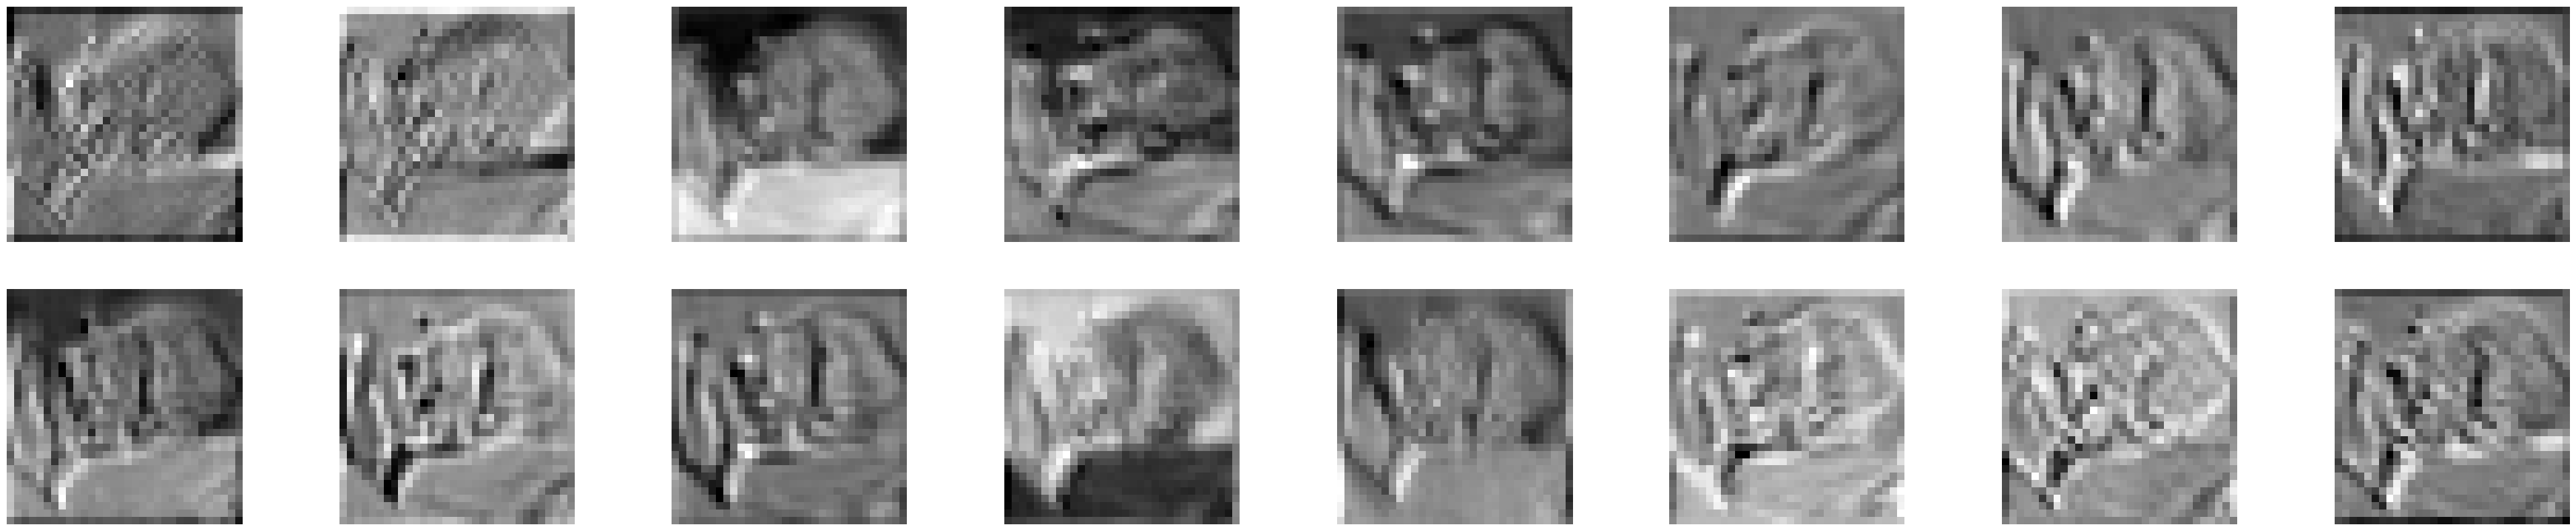

Layer  2


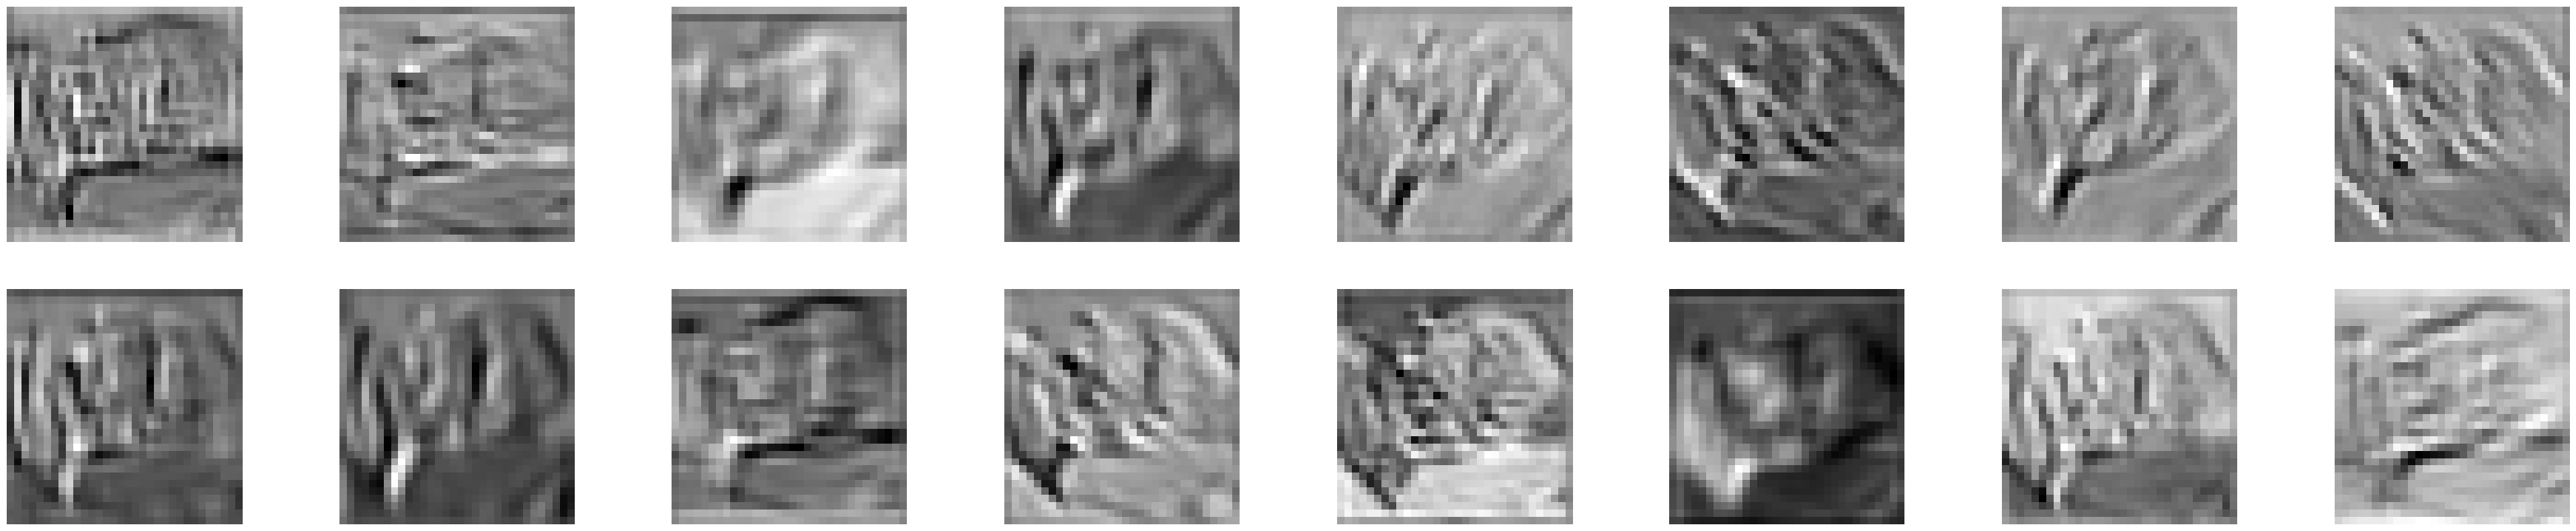

Layer  3


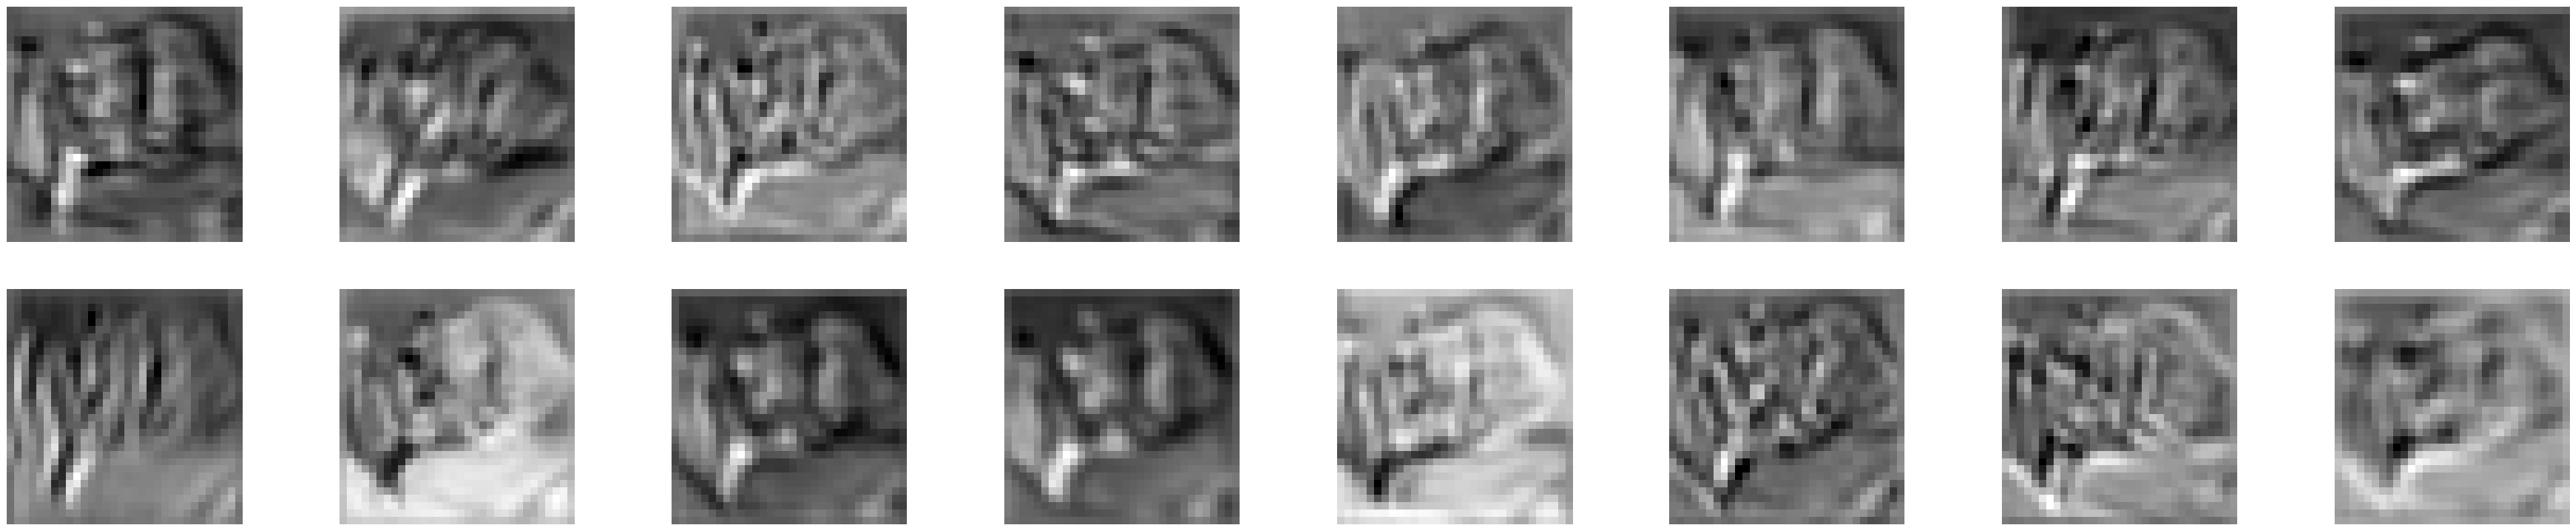

Layer  4


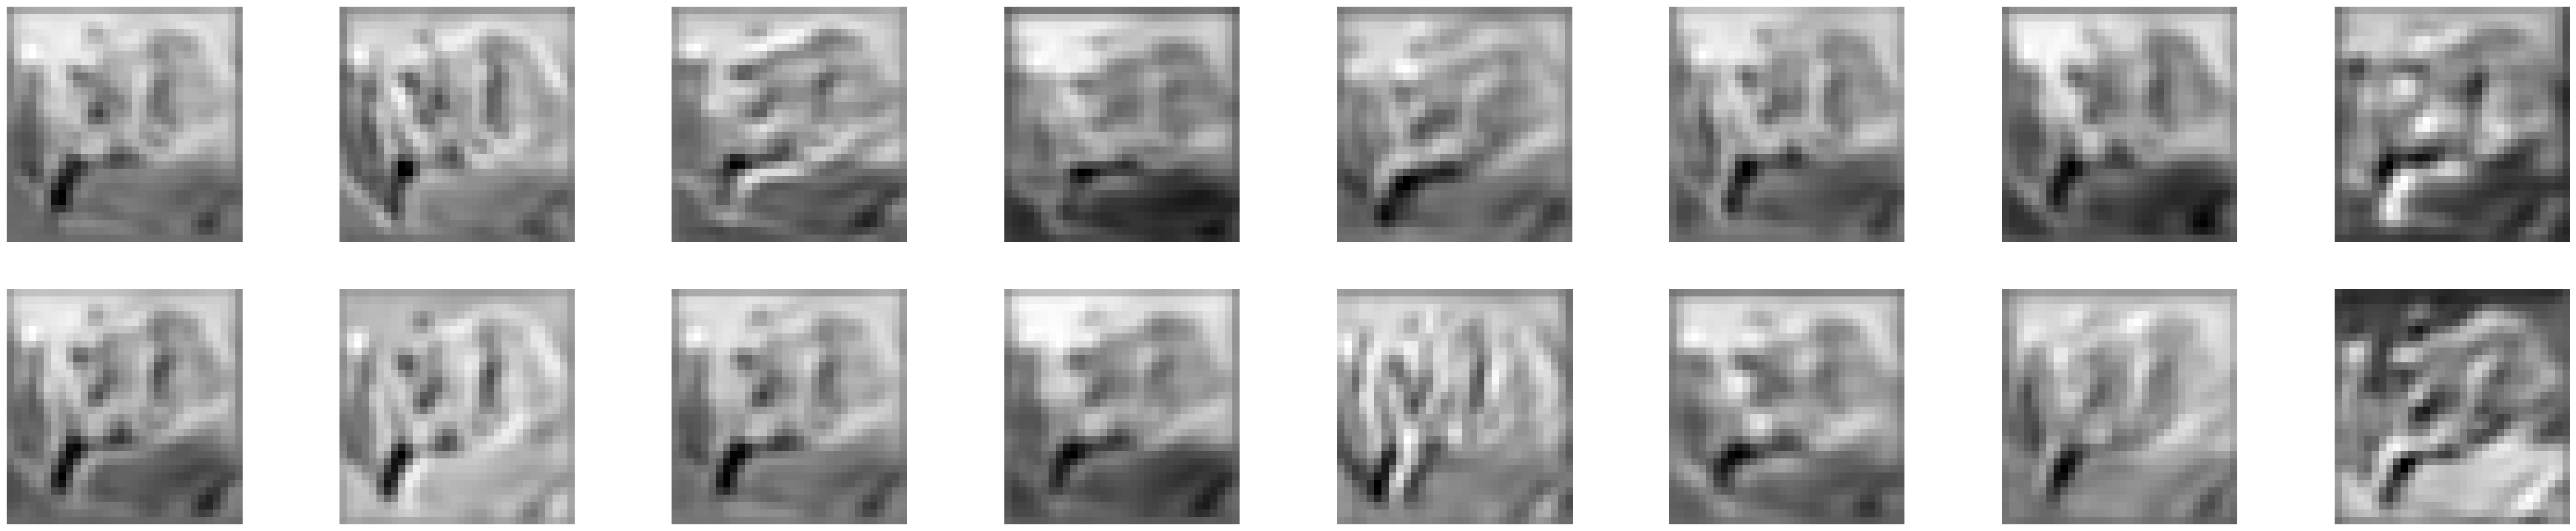

Layer  5


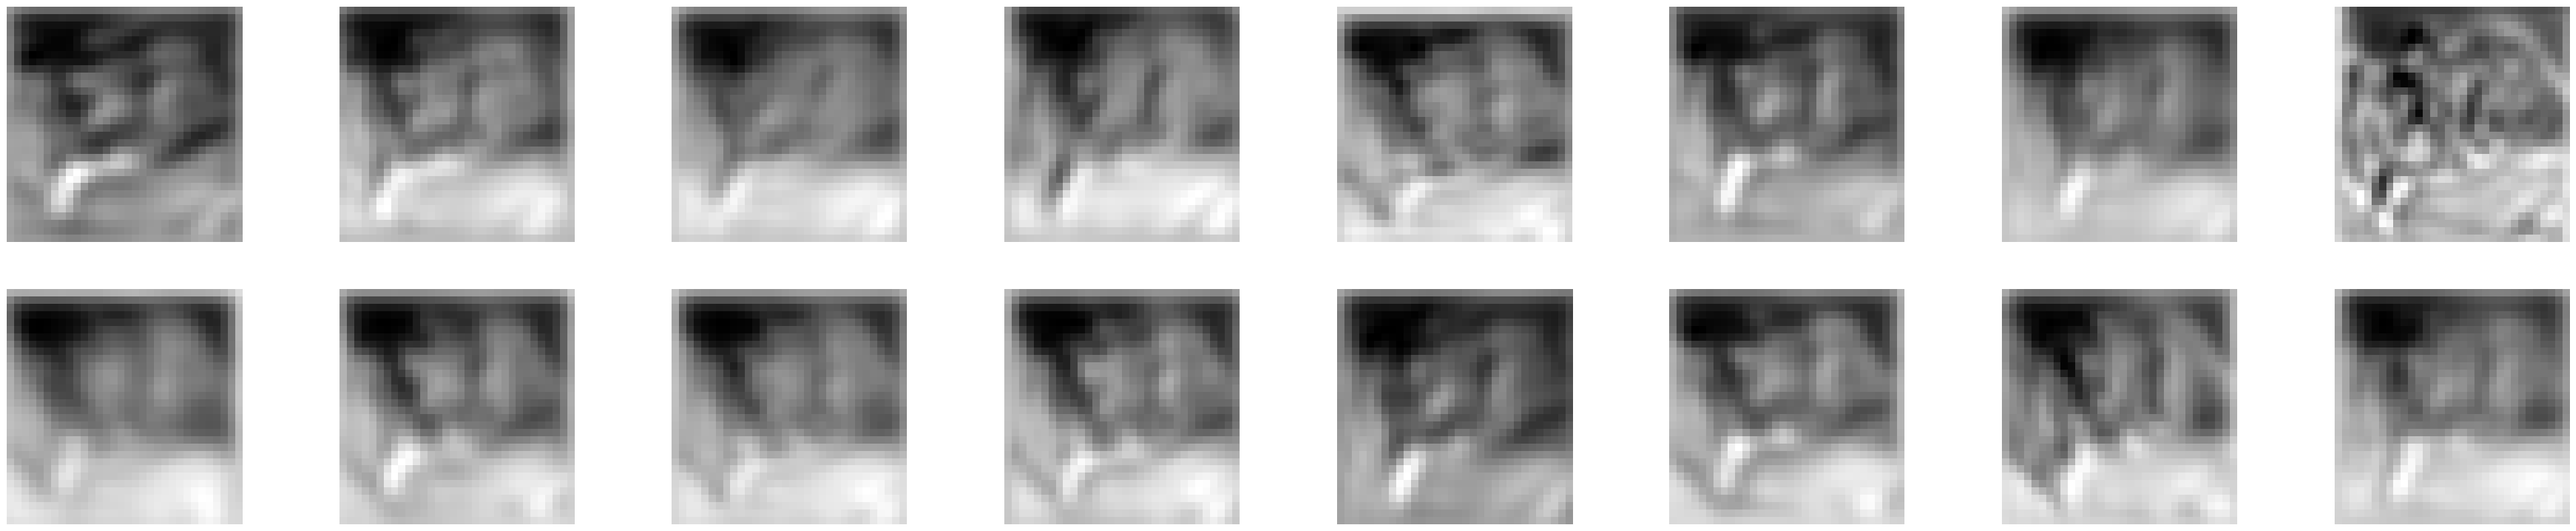

Layer  6


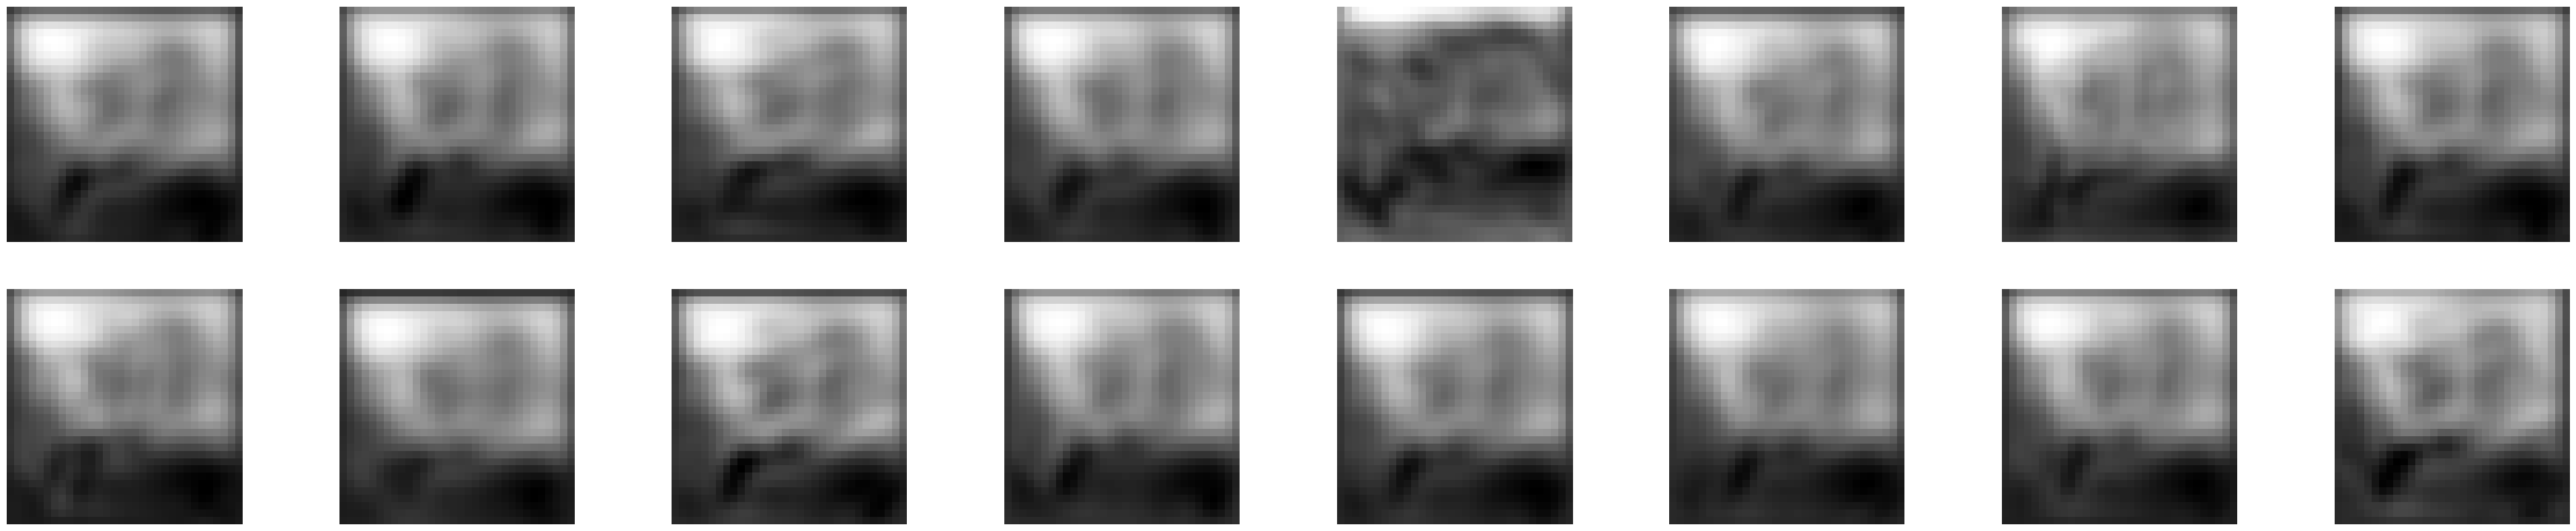

Layer  7


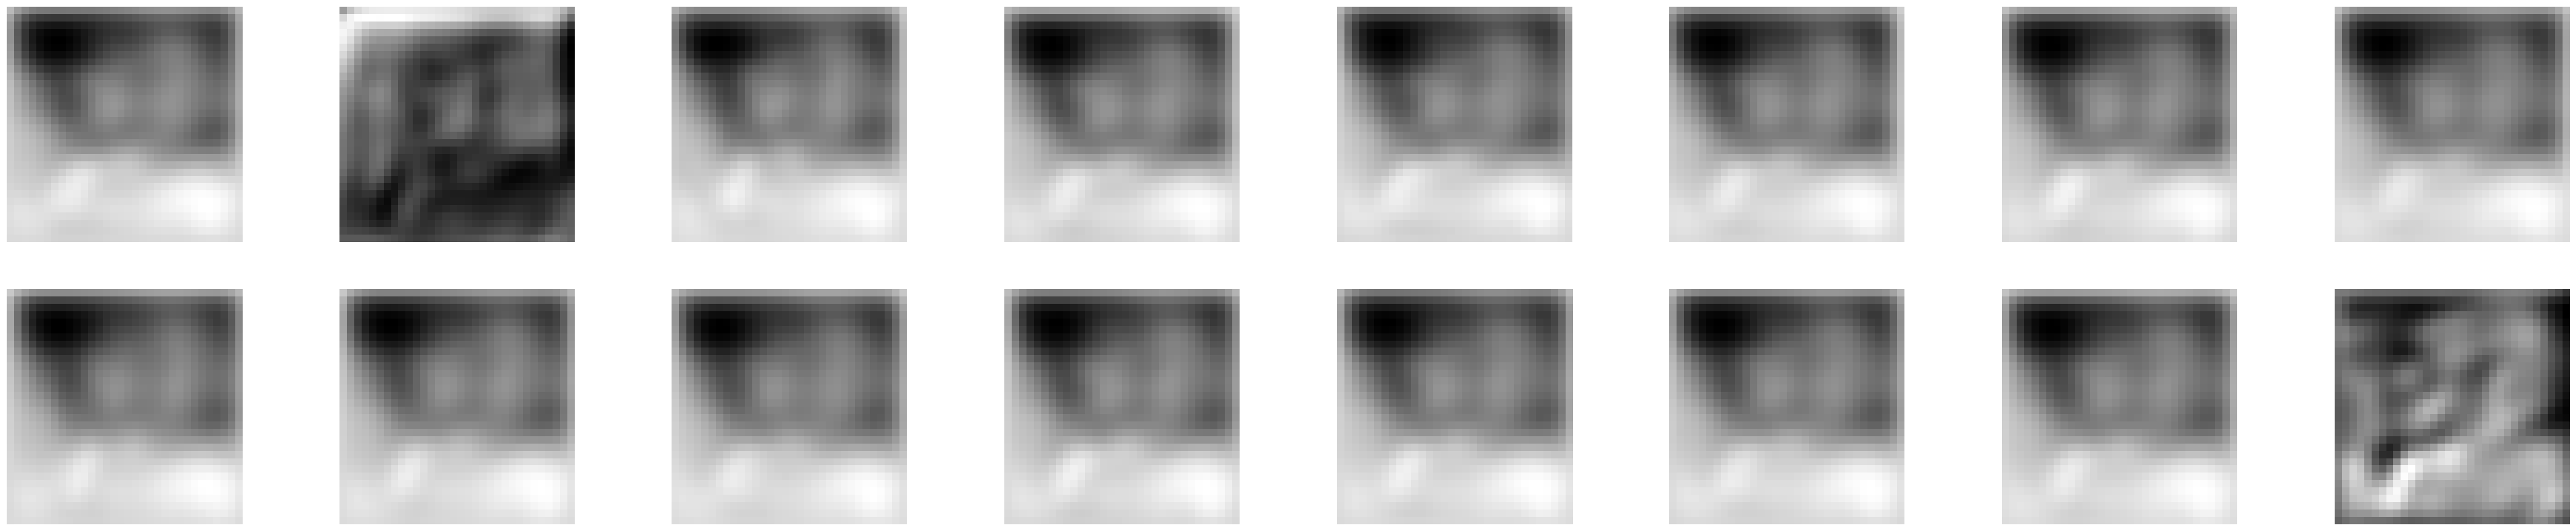

Layer  8


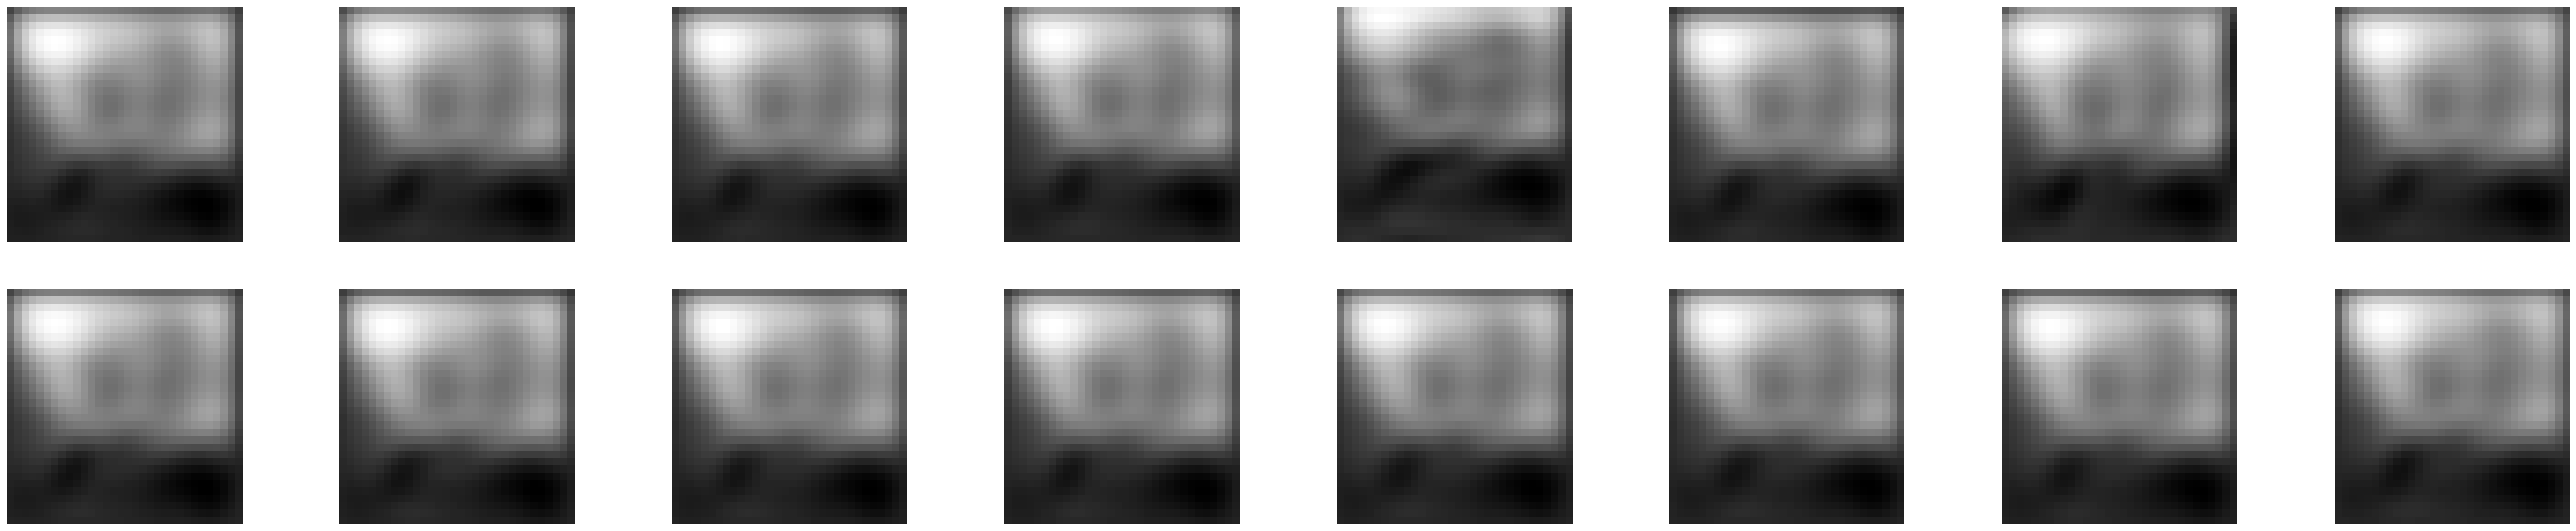

Layer  9


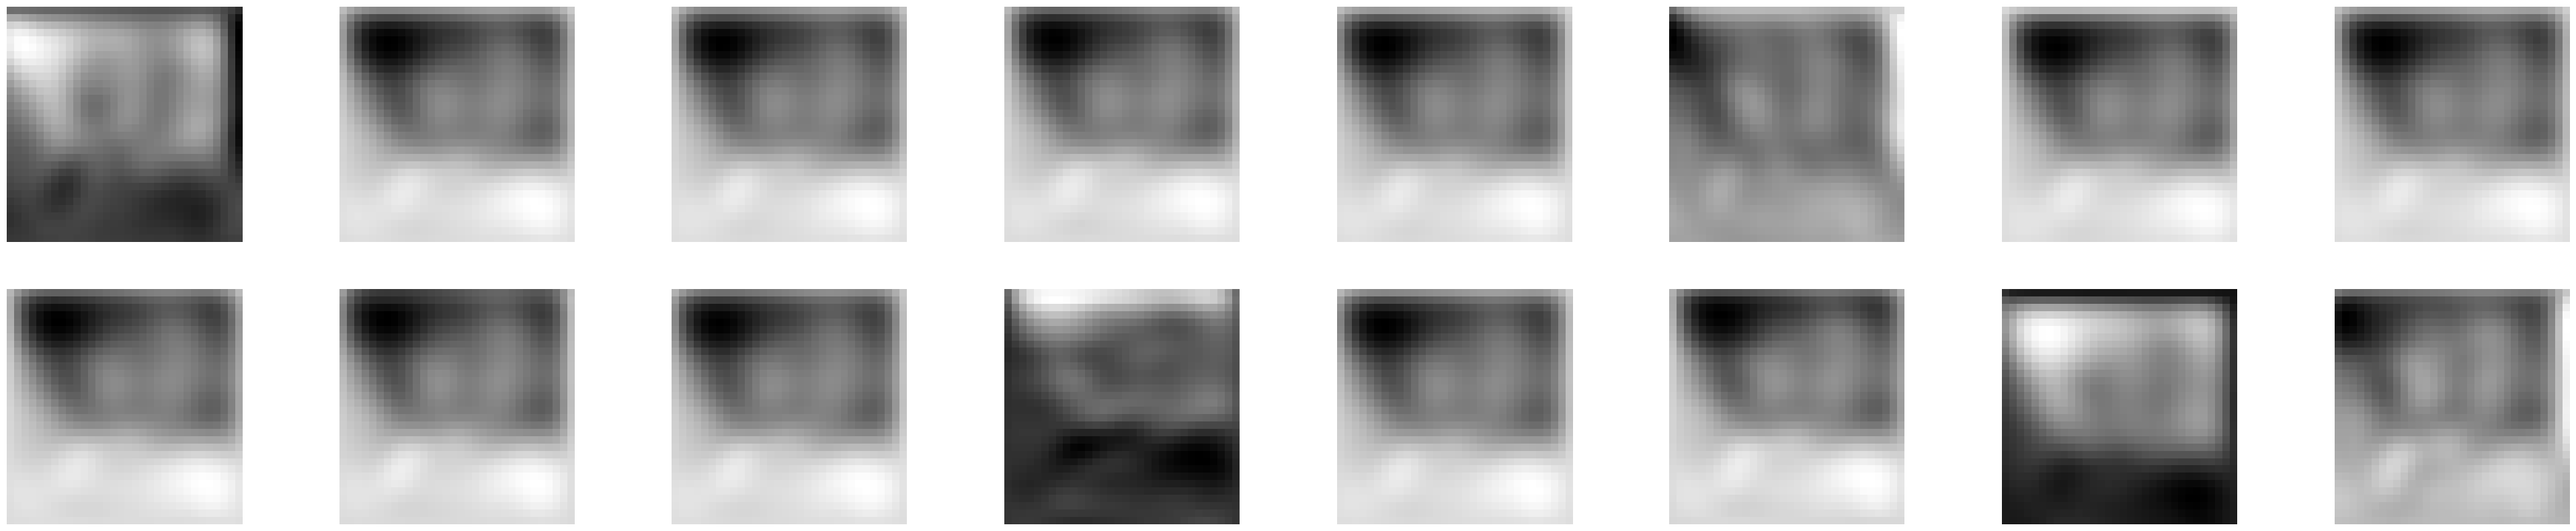

Layer  10


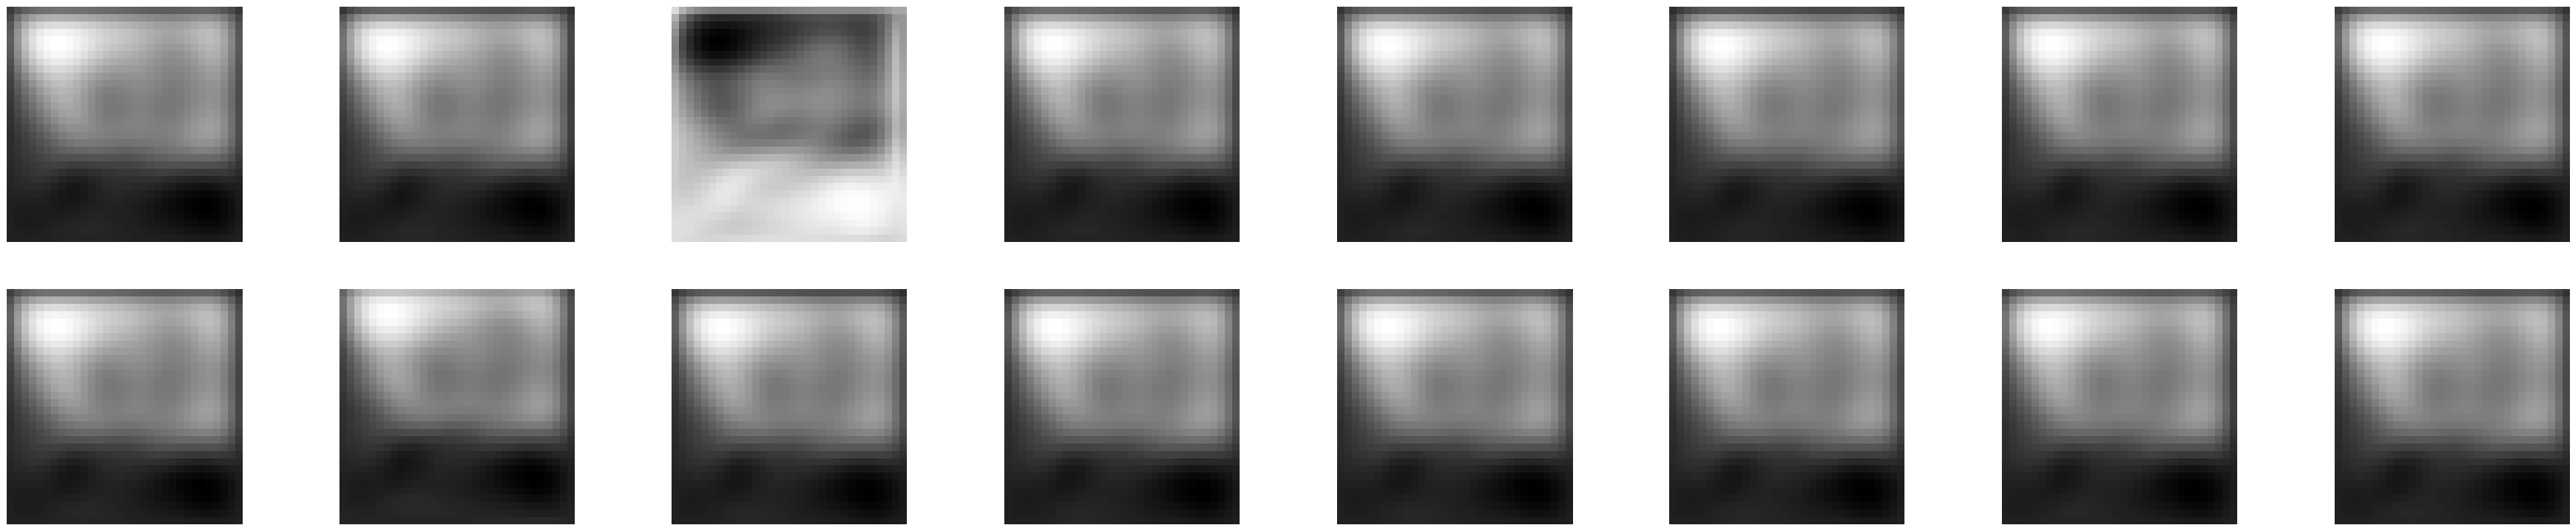

Layer  11


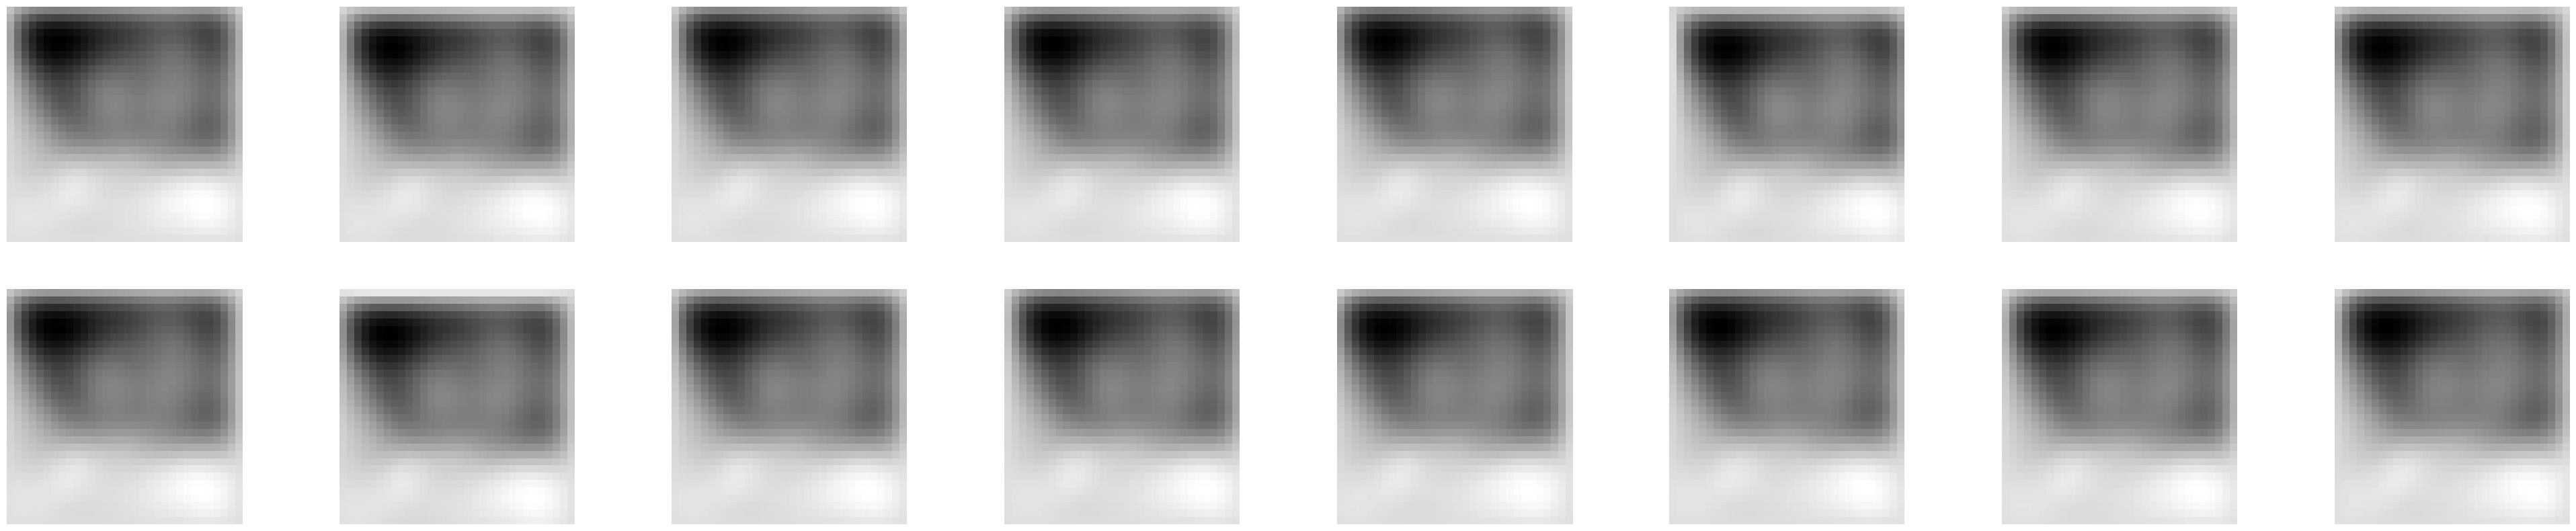

Layer  12


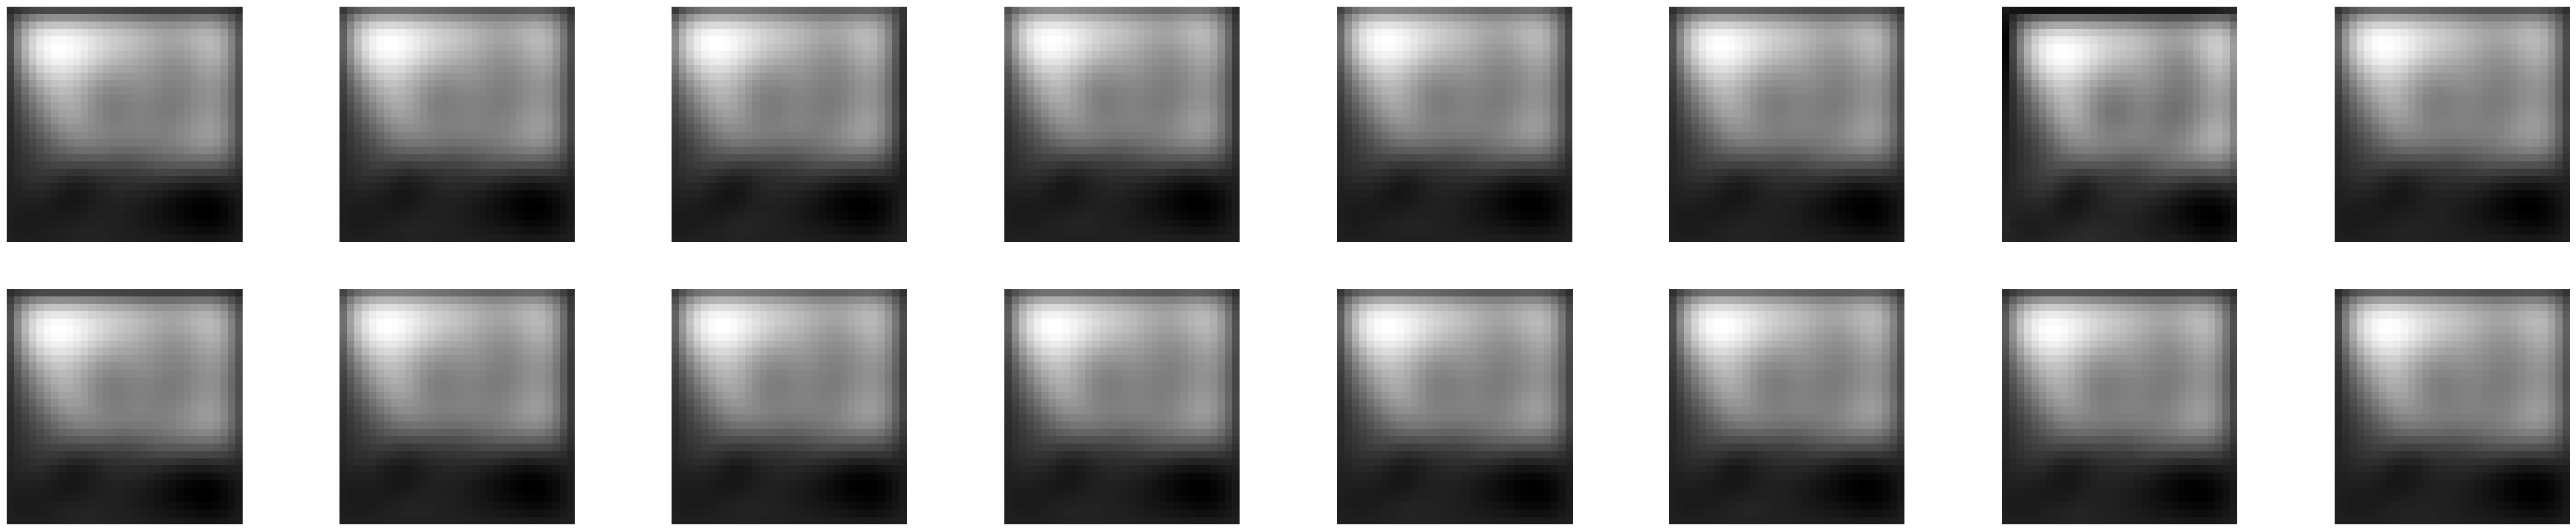

Layer  13


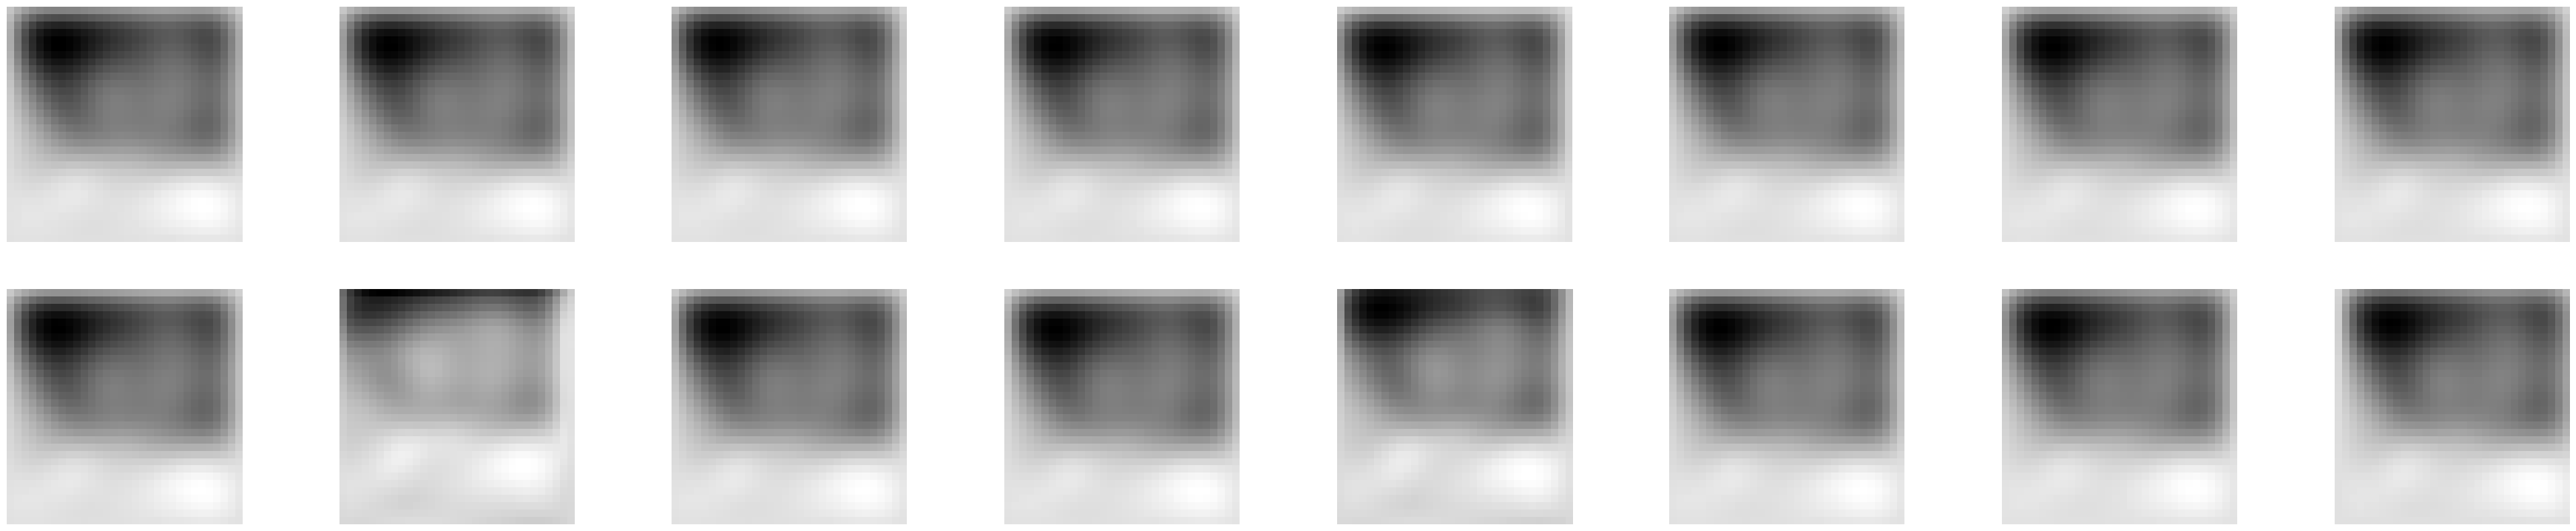

In [158]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()